<a href="https://colab.research.google.com/github/ssenichhh/Brain-Tumor-Detection-using-MRI-Images/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
"""Brain Tumor Detection using MRI images.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1fltCRIJLm_lp7TbmhC9D1jeAVFzxHmAS
"""

'Brain Tumor Detection using MRI images.ipynb\n\nAutomatically generated by Colab.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1fltCRIJLm_lp7TbmhC9D1jeAVFzxHmAS\n'

In [90]:
# Listing files in the current directory
!ls
# Installing the required package for image processing utilities
!pip install imutils

brain-mri-images-for-brain-tumor-detection.zip	TRAIN
brain_tumor_dataset				TRAIN_CROP
no						VAL
preview						VAL_CROP
sample_data					vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
TEST						yes
TEST_CROP


In [ ]:
# Ignoring warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Uploading files to Colab, typically for uploading Kaggle API credentials
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [ ]:
# Downloading the dataset from Kaggle
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 66% 10.0M/15.1M [00:00<00:00, 46.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 60.5MB/s]


In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


In [ ]:
from zipfile import ZipFile

In [ ]:
# Creating directories for train, test, and validation sets
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO


In [ ]:
# Extracting the downloaded dataset
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# Listing files in the current directory
!ls


brain-mri-images-for-brain-tumor-detection.zip	no	     TEST   VAL
brain_tumor_dataset				sample_data  TRAIN  yes


In [ ]:
# Defining the path to the images
IMG_PATH = '/content/brain_tumor_dataset'

# Splitting the dataset into train, test, and validation sets
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + '/' + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + '/' + CLASS)):
            img = IMG_PATH + '/' + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)


In [57]:
# Setting the image size for resizing
IMG_SIZE = (224,224)

In [ ]:
def load_data(dir_path, img_size=IMG_SIZE):
    """
    Load resized images as np.arrays to workspace

    Parameters:
    - dir_path: The directory path of the dataset
    - img_size: Tuple specifying the target size for the images

    Returns:
    - X: NumPy array of images
    - y: NumPy array of labels
    - labels: Dictionary mapping label indices to class names
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img_path = os.path.join(dir_path, path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size) # Resize the image
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Parameters:
    - cm: Confusion matrix
    - classes: List of class labels
    - normalize: Boolean to apply normalization
    - title: Title of the plot
    - cmap: Color map for the plot
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Defining directories for train, test, and validation sets
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# Loading the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 40.73it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


50 images loaded from VAL/ directory.


In [ ]:
# Installing Plotly for data visualization
!pip install plotly

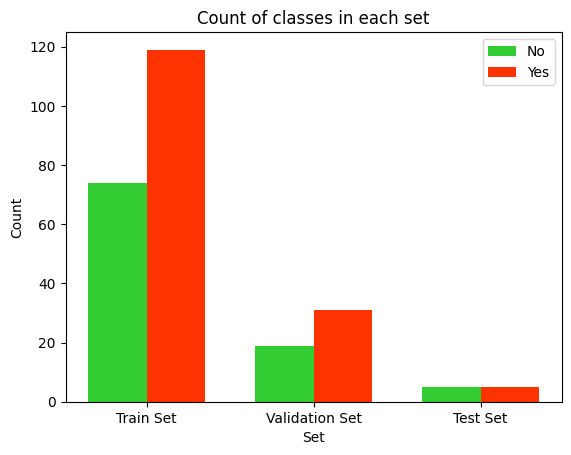

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Counting the number of images in each set
y = {0: [], 1: []}
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

# Plotting the count of classes in each set
labels = ['Train Set', 'Validation Set', 'Test Set']
width = 0.35  # width of the bars

fig, ax = plt.subplots()
ax.bar(np.arange(len(labels)) - width/2, y[0], width, label='No', color='#33cc33')
ax.bar(np.arange(len(labels)) + width/2, y[1], width, label='Yes', color='#ff3300')

# Adding titles and labels
ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_title('Count of classes in each set')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.legend()

# Displaying the plot
plt.show()



In [84]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set

    Parameters:
    - X: NumPy array of images
    - y: NumPy array of labels
    - labels_dict: Dictionary mapping label indices to class names
    - n: Number of samples to plot
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            img = img[0] # Extract image from the array
            img = np.clip(img, 0, 1)
            plt.subplot(i,j,c)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

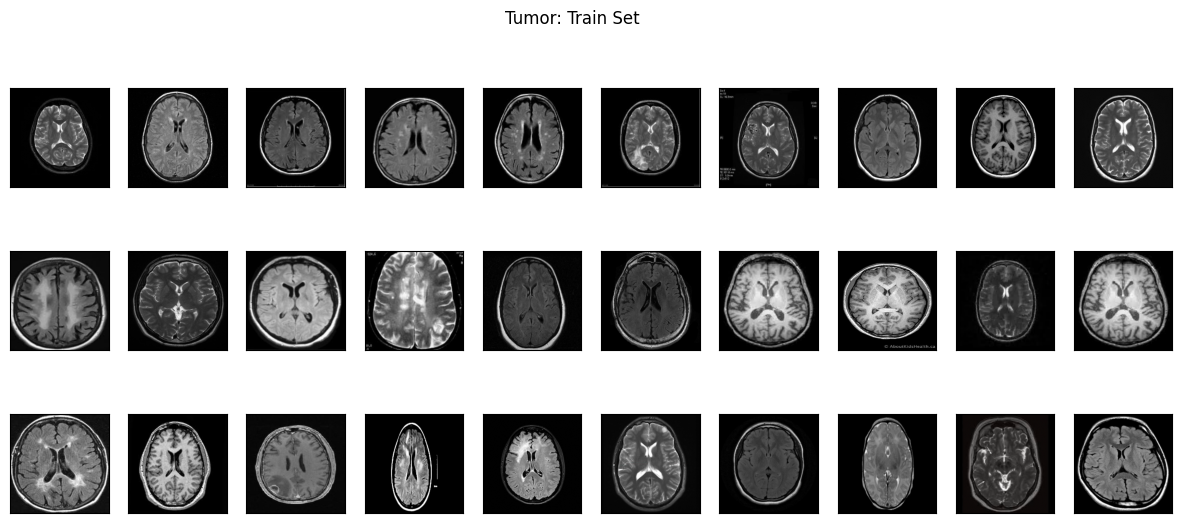

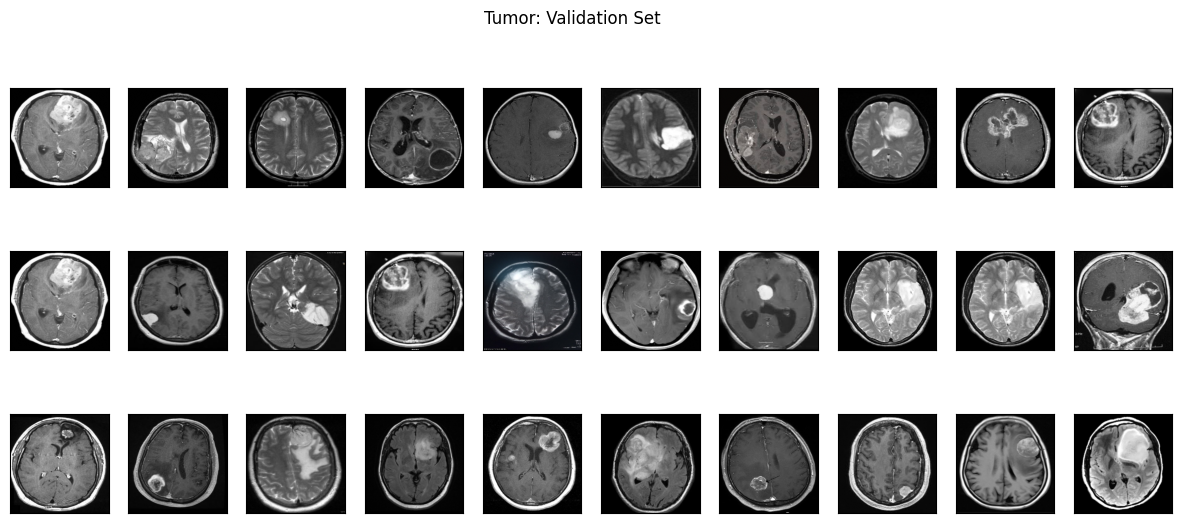

<Figure size 1500x600 with 0 Axes>

In [78]:
# Plotting sample images from the training set
plot_samples(X_train, y_train, labels, 30)

100%|██████████| 10/10 [00:00<00:00, 474.61it/s]


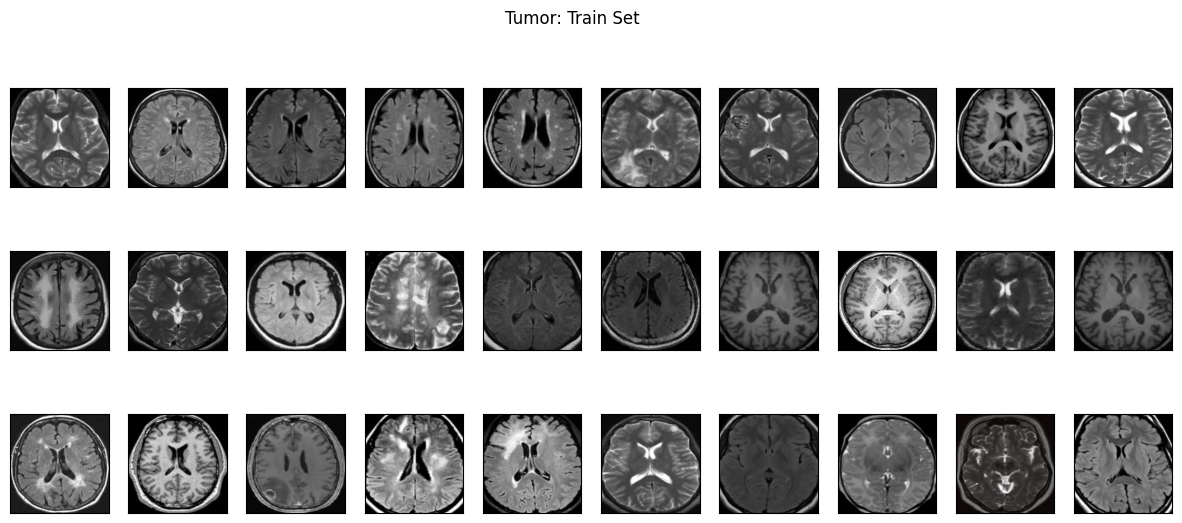

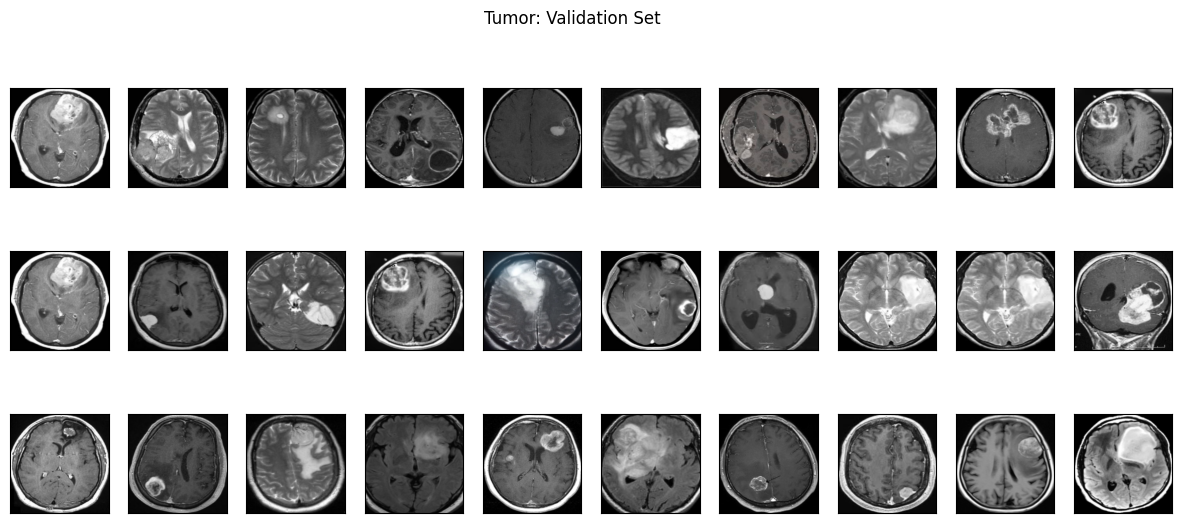

<Figure size 1500x600 with 0 Axes>

In [ ]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the target shape
TARGET_SHAPE = (224, 224, 3)

def resize_to_shape(img, target_shape):
    return cv2.resize(img, (target_shape[1], target_shape[0]))

def crop_imgs(set_name, add_pixels_value=0, target_shape=TARGET_SHAPE):
    """
    Finds the extreme points on the image and crops the rectangular out of them

    Parameters:
    - set_name: List of images to be cropped
    - add_pixels_value: Number of pixels to add around the detected region

    Returns:
    - Cropped images as NumPy array
    """
    set_new = []
    for img in tqdm(set_name):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold the image, then perform a series of erosions and dilations
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in the thresholded image and grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        # Resize the cropped image to the target shape
        new_img = resize_to_shape(new_img, target_shape)

        set_new.append(new_img)

    return np.array(set_new)

# Use the updated crop_imgs function
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

# Plot samples from the cropped training set
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
# Example of cropping images
img = cv2.imread('/content/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold the image, then perform a series of erosions and dilations
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# Find contours in thresholded image and grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# Find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# Add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# Add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# Crop the image
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

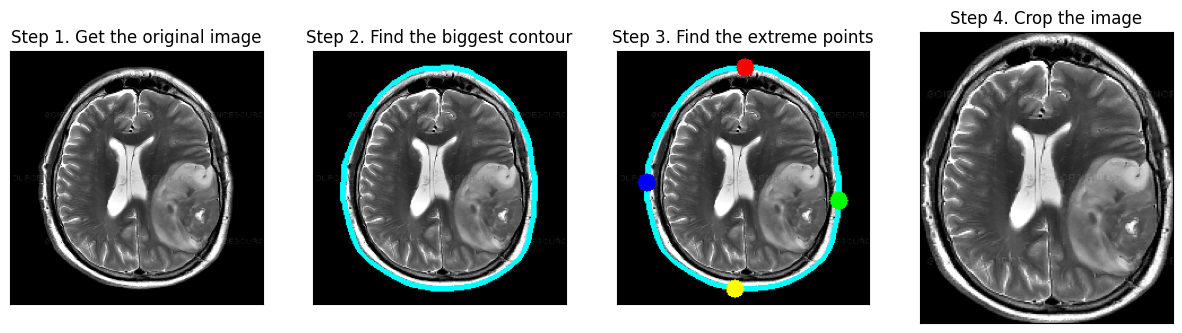

In [ ]:
# Displaying the original and processed images
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# Cropping the images in train, validation, and test sets
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

100%|██████████| 10/10 [00:00<00:00, 1403.29it/s]


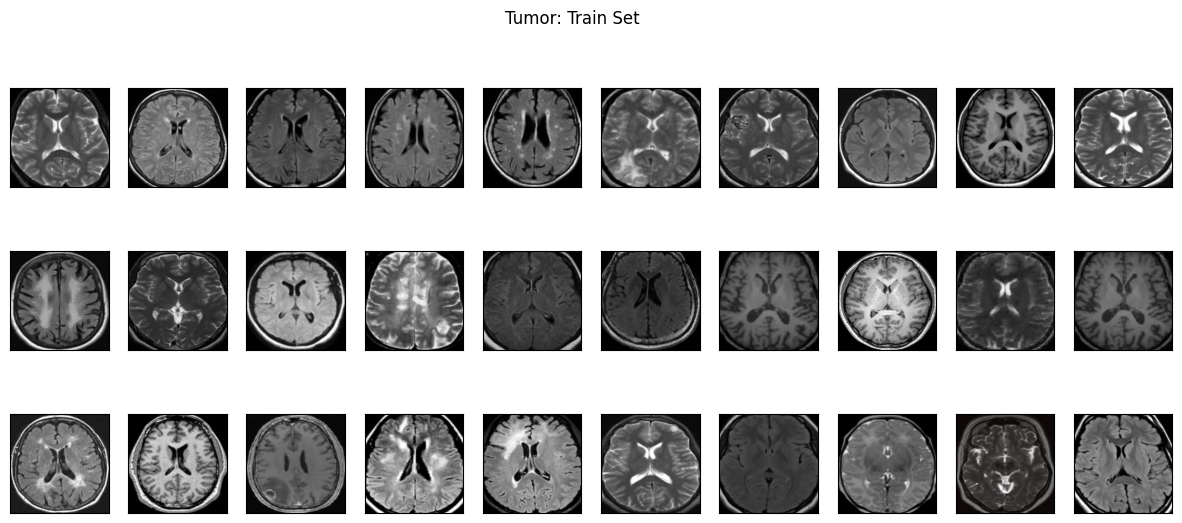

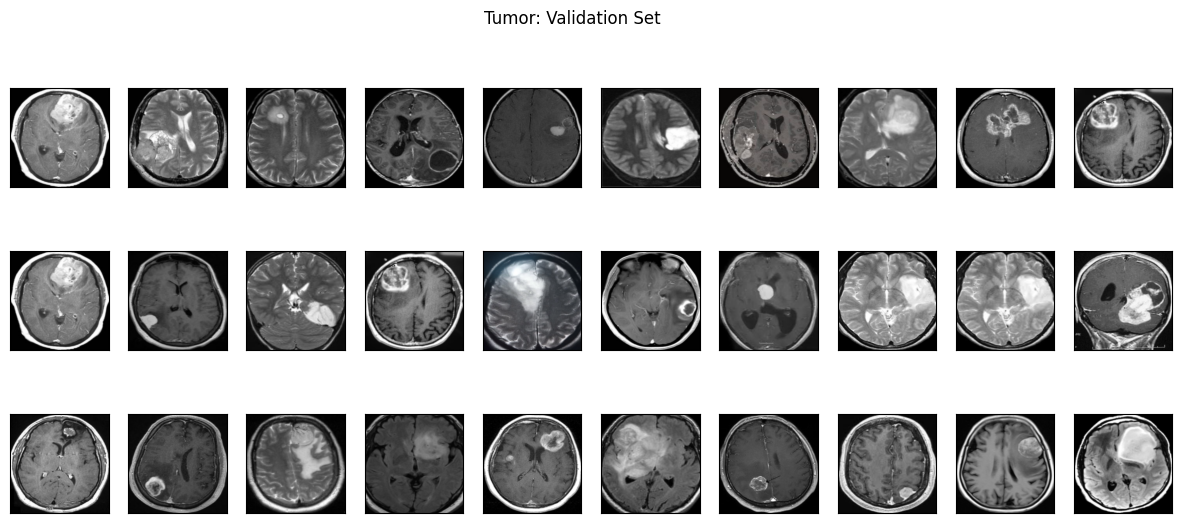

<Figure size 1500x600 with 0 Axes>

In [ ]:
# Plotting sample cropped images from the training set
plot_samples(X_train_crop, y_train, labels, 30)

In [72]:
import os
import cv2

def save_new_images(x_set, y_set, folder_name):
    """
    Saves the cropped images to the respective directories

    Parameters:
    - x_set: List of cropped images
    - y_set: List of corresponding labels
    - folder_name: Directory name to save the images
    """
    # Create subdirectories if they don't exist
    no_folder = os.path.join(folder_name, 'NO')
    yes_folder = os.path.join(folder_name, 'YES')

    os.makedirs(no_folder, exist_ok=True)
    os.makedirs(yes_folder, exist_ok=True)

    # Save images to the respective folders
    for i, img in enumerate(x_set):
        imclass = y_set[i]
        if imclass == 0:
            img_path = os.path.join(no_folder, f'{i}.jpg')
        else:
            img_path = os.path.join(yes_folder, f'{i}.jpg')
        cv2.imwrite(img_path, img)

In [73]:
# Saving the cropped images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [74]:
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [75]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing

    Parameters:
    - set_name: List of images to be preprocessed
    - img_size: Target size for resizing the images

    Returns:
    - Preprocessed images as NumPy array
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [76]:
# Preprocessing the cropped images
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

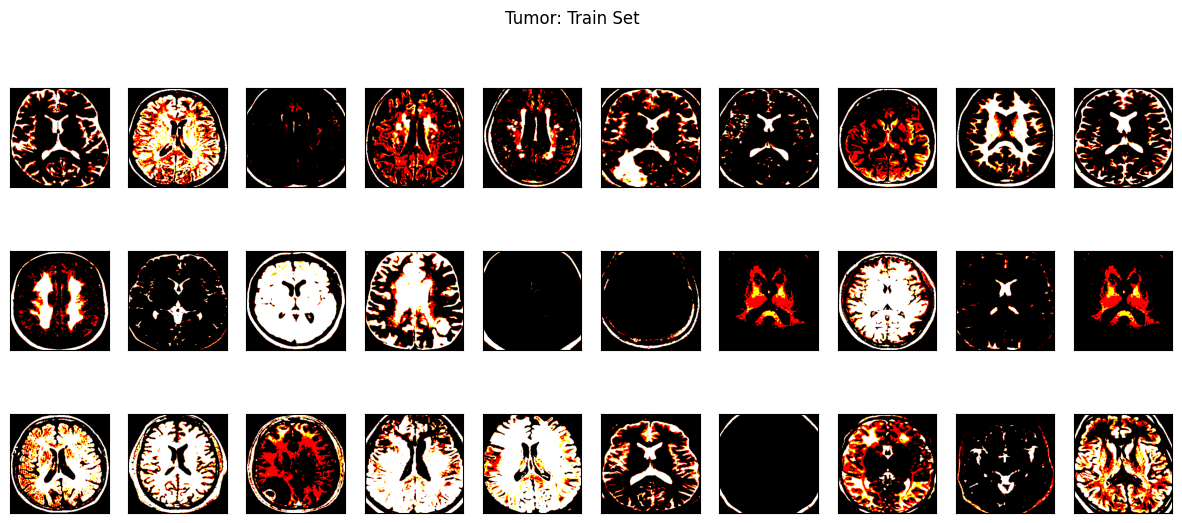

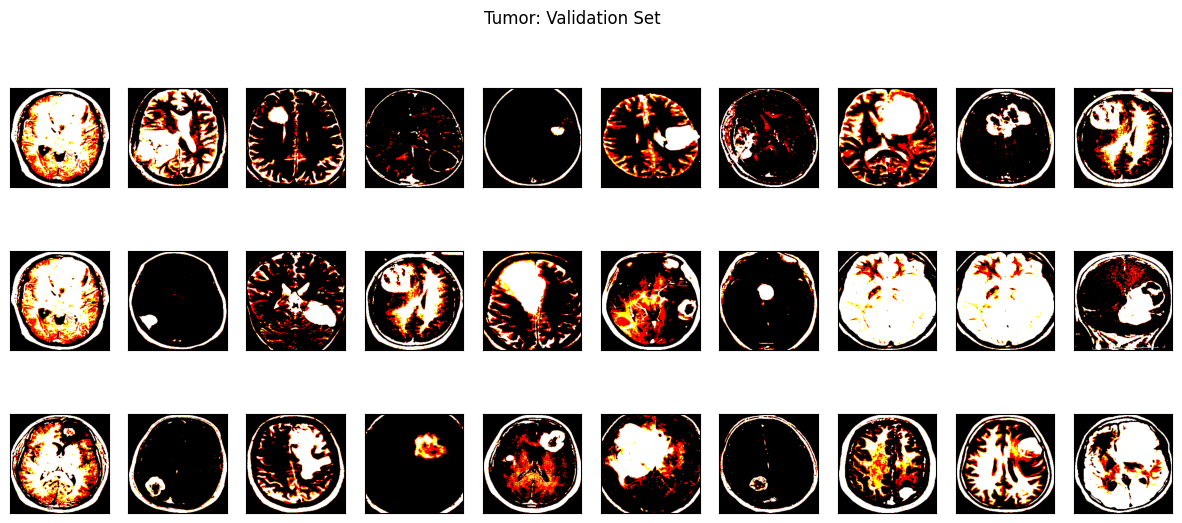

<Figure size 1500x600 with 0 Axes>

In [85]:
# Plotting sample preprocessed images from the training set
plot_samples(X_train_prep, y_train, labels, 30)

In [ ]:
# Data augmentation using ImageDataGenerator
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
# Creating a directory for preview images
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
# Generating augmented images
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

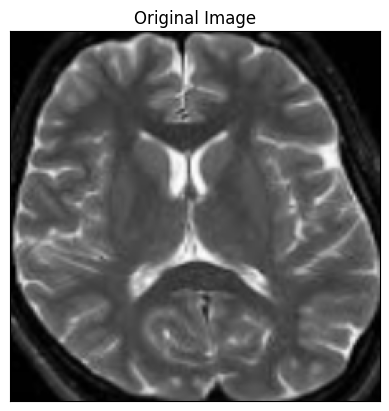

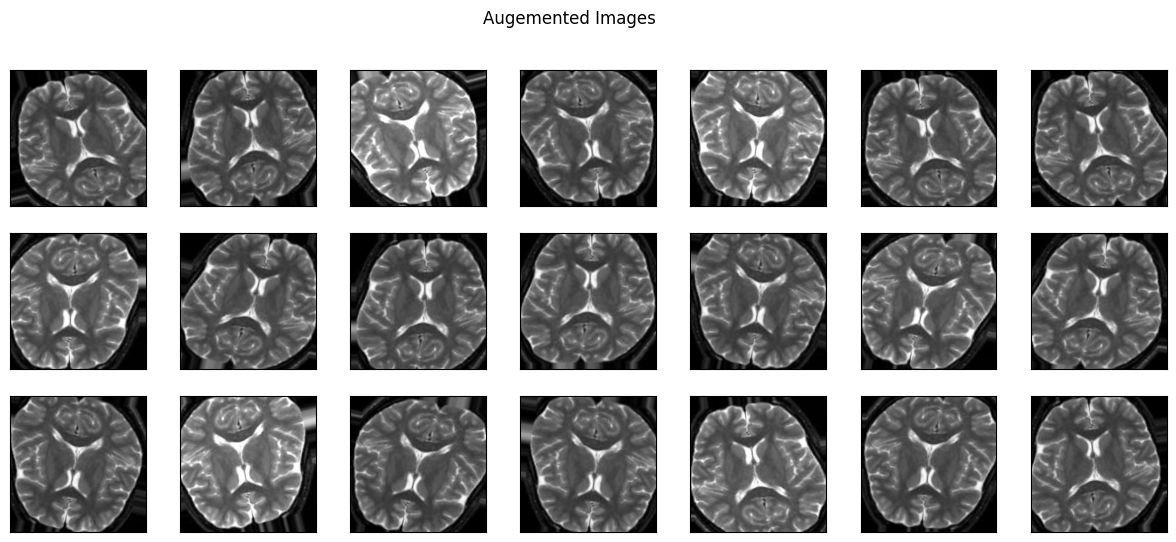

In [ ]:
# Displaying the original image
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

# Displaying augmented images
plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
# Defining directories for cropped train and validation sets
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

# Creating ImageDataGenerator instances for train and validation sets
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Creating data generators for train and validation sets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary'
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [89]:
# Loading VGG16 model with pre-trained weights
"""
The VGG16 model, introduced by Simonyan and Zisserman in 2014,
is a deep convolutional neural network that achieved
top performance on the ImageNet challenge.
It is characterized by its simplicity, using very small (3x3) convolution filters
 throughout the network and a fixed input size of 224x224 pixels.

Key Features of VGG16:

Convolutional Layers: The model has 13 convolutional layers that use 3x3 filters.

Max-Pooling Layers: There are 5 max-pooling layers to reduce the spatial
dimensions of the feature maps.

Fully Connected Layers: The model ends with 3 fully connected layers,
which are typically used for classification tasks.

Pre-trained Weights: The model can be loaded with pre-trained
weights from the ImageNet dataset, allowing it to leverage learned
features for various image recognition tasks.
"""
vgg16_weight_path = '/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [87]:
# Defining the model architecture
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# Freezing the base model layers
model.layers[0].trainable = False

# Compiling the model
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)
# Displaying the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [49]:
# Defining early stopping criteria
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

# Training the model
history = model.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    verbose=1
)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 9.7924 - accuracy: 0.6010 

7/7 [==============================] - 28s 2s/step - loss: 9.7924 - accuracy: 0.6010 - val_loss: 1.3369 - val_accuracy: 0.7600
Epoch 2/30
7/7 [==============================] - 4s 516ms/step - loss: 3.5947 - accuracy: 0.7565
Epoch 3/30
7/7 [==============================] - 3s 367ms/step - loss: 4.1552 - accuracy: 0.7358
Epoch 4/30
7/7 [==============================] - 3s 363ms/step - loss: 2.2216 - accuracy: 0.8083
Epoch 5/30
7/7 [==============================] - 3s 415ms/step - loss: 2.8456 - accuracy: 0.7876
Epoch 6/30
7/7 [==============================] - 3s 371ms/step - loss: 4.5000 - accuracy: 0.7202
Epoch 7/30
7/7 [==============================] - 3s 371ms/step - loss: 2.6806 - accuracy: 0.7824
Epoch 8/30
7/7 [==============================] - 3s 366ms/step - loss: 1.6937 - accuracy: 0.8549
Epoch 9/30
7/7 [==============================] - 4s 503ms/step - loss: 3.8339 - accuracy: 0.7668
Epoch 10/30
7/7 [==============================] - 3s 368ms/step - loss: 1.8833 - accurac

In [50]:
# Extracting training history
history.history

{'loss': [9.792364120483398,
  3.594683885574341,
  4.155226707458496,
  2.2216296195983887,
  2.845634698867798,
  4.499965667724609,
  2.680635929107666,
  1.6937015056610107,
  3.833930015563965,
  1.8832999467849731,
  1.4386650323867798,
  1.5013171434402466,
  1.5668708086013794,
  1.7362045049667358,
  1.719997763633728,
  1.888552188873291,
  2.3121020793914795,
  2.433854579925537,
  1.5368874073028564,
  2.2407214641571045,
  1.1282427310943604,
  0.9067150950431824,
  0.7518022656440735,
  1.2500027418136597,
  1.351405382156372,
  1.4209280014038086,
  1.1090161800384521,
  0.601692795753479,
  1.1197797060012817,
  1.1836363077163696],
 'accuracy': [0.6010362505912781,
  0.7564767003059387,
  0.7357512712478638,
  0.8082901835441589,
  0.787564754486084,
  0.7202072739601135,
  0.7823834419250488,
  0.8549222946166992,
  0.7668393850326538,
  0.8290155529975891,
  0.8445596098899841,
  0.9015544056892395,
  0.8549222946166992,
  0.8341968655586243,
  0.9015544056892395,
  

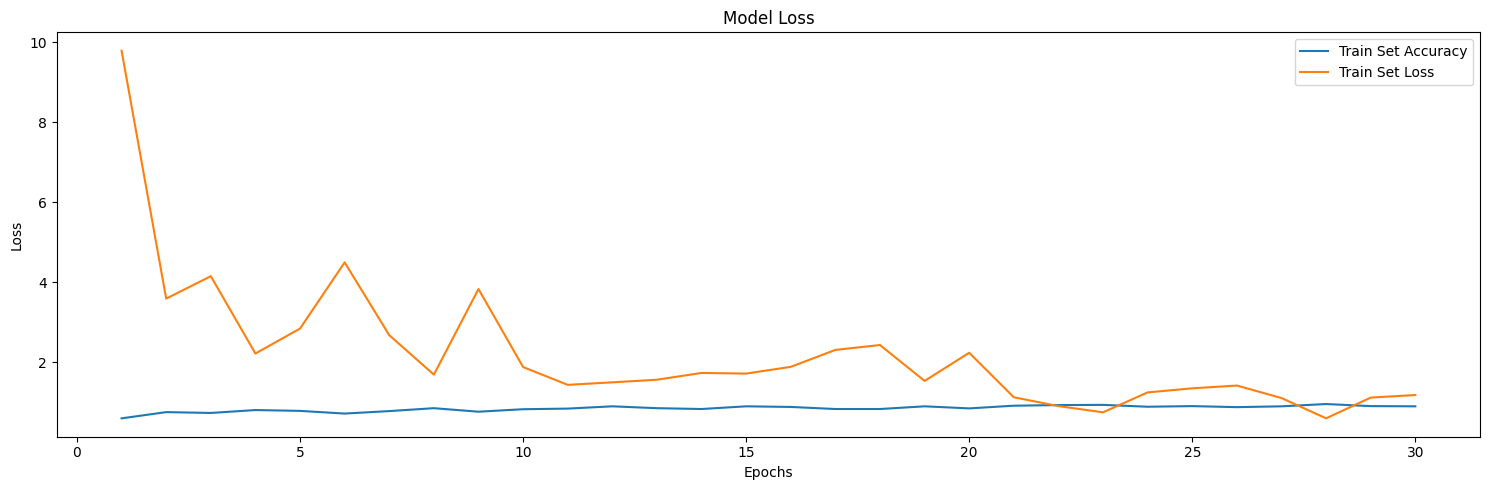

In [86]:
# Plotting model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, acc, label='Train Set Accuracy')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Train Set Loss')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

2/2 [==============================] - 0s 163ms/step
Val Accuracy = 0.56


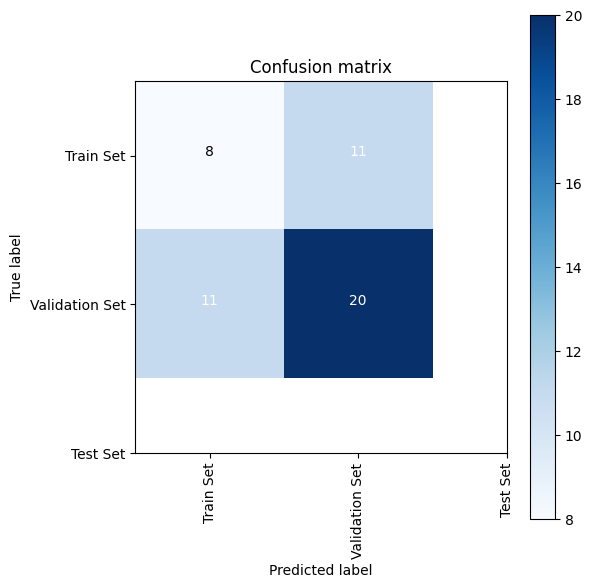

In [88]:
# Validating the model on the validation set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)

# Plotting the confusion matrix
classes = labels  # Directly use it if it's already a list

# Now you can use classes to label your confusion matrix plot
cm = plot_confusion_matrix(confusion_mtx, classes=classes, normalize=False)